In [31]:
import yaml
import random
import numpy as np
import pandas as pd
from scipy.stats import entropy as scipy_entropy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.font_manager import FontProperties
import time

POPULATION_SIZE = 200
ELITE_PROPORTION = 0.1
MUTANT_PROPORTION = 0.2
RHO_E = 0.5
MAX_GENERATION_NUMBER = 50
MAX_FITNESS = 1.0
RESTART_THRESHOLD = 10
RESTART_PROPORTION = 0.5

RAW_DATA_FILE = "raw_data.yml"

with open(RAW_DATA_FILE, 'r') as raw_data_file:
    RAW_DATA = yaml.safe_load(raw_data_file)

classes = RAW_DATA["classes"]
cols = RAW_DATA["course_mapping"]
rooms = RAW_DATA["rooms"]
days = RAW_DATA["days"]
hours = RAW_DATA["hours"]

LEN_ROOMS = sum(rooms["number"])
LEN_CLASSES = len(classes)
LEN_DAYS = len(days)
LEN_HOURS = len(hours)
LEN_COLS = len(cols)
LEN_ROWS = LEN_CLASSES * LEN_DAYS * LEN_HOURS
shape = (LEN_ROWS, LEN_COLS)

def check_feasibility(verbose=True):
    total_units_needed = sum([units for _, _, _, units in cols]) * LEN_CLASSES
    total_slots_available = LEN_DAYS * LEN_HOURS * LEN_ROOMS

    # Print geral
    if verbose:
        print("\n📊 Análise Geral de Viabilidade:")
        print(f"- Unidades letivas totais necessárias: {total_units_needed}")
        print(f"- Slots totais disponíveis (todas as salas): {total_slots_available}")
        print(f"- Diferença: {total_slots_available - total_units_needed} slots livres\n")

    # Verificação por tipo de sala
    room_type_to_count = {rtype: qty for rtype, qty in zip(rooms["type"], rooms["number"])}
    required_units_by_room_type = {rtype: 0 for rtype in rooms["type"]}
    available_slots_by_room_type = {}

    for subject, room_type, _, units in cols:
        required_units_by_room_type[room_type] += units * LEN_CLASSES

    if verbose:
        print("🏫 Análise por Tipo de Sala:")
    for room_type, required_units in required_units_by_room_type.items():
        available_slots = room_type_to_count[room_type] * LEN_DAYS * LEN_HOURS
        available_slots_by_room_type[room_type] = available_slots

        if verbose:
            print(f"- {room_type}:")
            print(f"   • Requerido: {required_units} slots")
            print(f"   • Disponível: {available_slots} slots")
            print(f"   • Diferença: {available_slots - required_units}\n")

        if required_units > available_slots:
            raise ValueError(
                f"Alocação impossível para salas do tipo '{room_type}':\n"
                f"Requerido = {required_units} | Disponível = {available_slots}"
            )

    # Verificação por professor
    required_units_by_professor = {}
    max_slots_per_professor = LEN_DAYS * LEN_HOURS  # 1 aula por slot

    for _, _, professor, units in cols:
        required_units_by_professor.setdefault(professor, 0)
        required_units_by_professor[professor] += units * LEN_CLASSES

    if verbose:
        print("👨‍🏫 Análise por Professor:")
    for professor, required_units in required_units_by_professor.items():
        if verbose:
            print(f"- {professor}:")
            print(f"   • Requerido: {required_units} slots")
            print(f"   • Disponível: {max_slots_per_professor}")
            print(f"   • Diferença: {max_slots_per_professor - required_units}\n")

        if required_units > max_slots_per_professor:
            raise ValueError(
                f"O professor '{professor}' tem carga horária excessiva: "
                f"{required_units} unidades letivas atribuídas, mas só há {max_slots_per_professor} slots disponíveis."
            )

    if verbose:
        print("✅ Alocação viável: recursos suficientes no total, por tipo de sala e por professor.\n")


check_feasibility()


📊 Análise Geral de Viabilidade:
- Unidades letivas totais necessárias: 448
- Slots totais disponíveis (todas as salas): 660
- Diferença: 212 slots livres

🏫 Análise por Tipo de Sala:
- Sala:
   • Requerido: 288 slots
   • Disponível: 440 slots
   • Diferença: 152

- Lab:
   • Requerido: 160 slots
   • Disponível: 220 slots
   • Diferença: 60

👨‍🏫 Análise por Professor:
- Paes:
   • Requerido: 48 slots
   • Disponível: 55
   • Diferença: 7

- Willy:
   • Requerido: 32 slots
   • Disponível: 55
   • Diferença: 23

- Marina:
   • Requerido: 24 slots
   • Disponível: 55
   • Diferença: 31

- Carlos:
   • Requerido: 16 slots
   • Disponível: 55
   • Diferença: 39

- Ana:
   • Requerido: 24 slots
   • Disponível: 55
   • Diferença: 31

- Roberto:
   • Requerido: 16 slots
   • Disponível: 55
   • Diferença: 39

- Felipe:
   • Requerido: 24 slots
   • Disponível: 55
   • Diferença: 31

- Xu:
   • Requerido: 48 slots
   • Disponível: 55
   • Diferença: 7

- Maria:
   • Requerido: 24 slots
   •

In [32]:
def get_entropy(individual, class_name, threshold=0.0):
    u_per_day_mat = np.zeros((LEN_COLS, LEN_DAYS), dtype=np.uint8)
    class_index = classes.index(class_name)

    for day in range(LEN_DAYS):
        for hour in range(LEN_HOURS):
            for row in range(LEN_COLS):
                idx = hour + day * LEN_HOURS + class_index * LEN_DAYS * LEN_HOURS
                if individual["genes"][idx, row] > 0:
                    u_per_day_mat[row, day] += 1

    total_entropy = 0.0
    for row in range(u_per_day_mat.shape[0]):
        row_sum = np.sum(u_per_day_mat[row, :])
        if row_sum > 0:
            entropy = scipy_entropy(u_per_day_mat[row, :], base=2)
            if entropy > threshold:
                total_entropy += entropy
    return total_entropy / LEN_COLS

def init_individual():
    base_order = sorted(range(len(cols)), key=lambda i: -cols[i][3])
    keys = np.zeros(len(cols))
    for rank, col_idx in enumerate(base_order):
        keys[col_idx] = (len(cols) - rank) / len(cols)
    noise = np.random.normal(0, 0.05, len(cols))
    keys = np.clip(keys + noise, 0.0, 1.0)
    return keys

def mutate_keys(keys, rate=0.05):
    mutated = keys.copy()
    for i in range(len(mutated)):
        if random.random() < rate:
            mutated[i] = random.random()
    return mutated

def decode_individual(keys):
    chromosome = list(np.argsort(keys))
    individual = {
        "keys": keys,
        "chromosome": chromosome,
        "available_room": np.zeros((LEN_DAYS * LEN_HOURS, LEN_ROOMS), dtype=np.int8),
        "genes": np.zeros(shape, dtype=np.int32)
    }
    return fill_genes_brkga(individual)

def fill_genes_brkga(ind):
    # Dicionário para controlar a agenda dos professores
    professor_schedule = {}

    for working_column in ind["chromosome"]:
        subject, room_type, lecturer, units = cols[working_column]
        for clss in range(LEN_CLASSES):
            start = clss * LEN_DAYS * LEN_HOURS
            allocated_units = 0
            for day in range(LEN_DAYS):
                for hour in range(LEN_HOURS):
                    if allocated_units >= units:
                        break
                    # Verifica se o professor já está ocupado nesse horário
                    if professor_schedule.get((day, hour, lecturer), False):
                        continue

                    row = start + day * LEN_HOURS + hour
                    tmp_i = rooms["type"].index(room_type)
                    s = sum(rooms["number"][:tmp_i])
                    e = s + rooms["number"][tmp_i] - 1
                    for room in range(s, e + 1):
                        if ind["genes"][row, working_column] == 0 and ind["available_room"][row % (LEN_DAYS * LEN_HOURS), room] == 0:
                            # Marca alocação
                            ind["genes"][row, working_column] = room + 1
                            ind["available_room"][row % (LEN_DAYS * LEN_HOURS), room] = 1

                            # Bloqueia este horário para o professor
                            professor_schedule[(day, hour, lecturer)] = True

                            # Marca indisponibilidade para outras turmas e disciplinas
                            base = row % (LEN_DAYS * LEN_HOURS)
                            for clss2 in range(LEN_CLASSES):
                                if clss2 != clss:
                                    ind["genes"][base + clss2 * LEN_DAYS * LEN_HOURS, working_column] = -1
                            for col in range(LEN_COLS):
                                if col != working_column:
                                    ind["genes"][row, col] = -1
                            allocated_units += 1
                            break
                if allocated_units >= units:
                    break
    return ind


def evaluate(ind):
    scheduled_units = 0
    expected_units = sum([units for _, _, _, units in cols]) * LEN_CLASSES
    unallocated_units = 0
    for col_idx, (_, _, _, units) in enumerate(cols):
        for class_idx in range(LEN_CLASSES):
            base = class_idx * LEN_DAYS * LEN_HOURS
            allocated = sum(ind["genes"][base + i, col_idx] > 0 for i in range(LEN_DAYS * LEN_HOURS))
            if allocated == 0:
                unallocated_units += units
            scheduled_units += allocated
    fitness = scheduled_units / expected_units
    entropy_penalty = sum(get_entropy(ind, clss) for clss in classes) / LEN_CLASSES
    fitness -= entropy_penalty * 0.05
    fitness -= unallocated_units / expected_units * 0.3
    return (fitness, scheduled_units / expected_units * 100)

def biased_crossover(parent1, parent2):
    return np.where(np.random.rand(len(parent1)) < RHO_E, parent1, parent2)

def run_brkga():
    population = [decode_individual(init_individual()) for _ in range(POPULATION_SIZE)]
    best_solution = None
    best_fitness = -np.inf
    stagnation_counter = 0
    for generation in range(MAX_GENERATION_NUMBER):
        population.sort(key=lambda ind: evaluate(ind)[0], reverse=True)
        elites = population[:int(ELITE_PROPORTION * POPULATION_SIZE)]
        mutants = [decode_individual(init_individual()) for _ in range(int(MUTANT_PROPORTION * POPULATION_SIZE))]
        offspring = []
        while len(offspring) < POPULATION_SIZE - len(elites) - len(mutants):
            elite_parent = random.choice(elites)
            non_elite_parent = random.choice(population[len(elites):])
            child_keys = biased_crossover(elite_parent["keys"], non_elite_parent["keys"])
            child_keys = mutate_keys(child_keys)
            offspring.append(decode_individual(child_keys))
        population = elites + offspring + mutants
        current_best = population[0]
        current_fitness, allocation_pct = evaluate(current_best)
        print(f"Geração {generation + 1}: Fitness = {current_fitness:.4f} | Alocação = {allocation_pct:.2f}%")
        if current_fitness > best_fitness:
            best_solution = current_best
            best_fitness = current_fitness
            stagnation_counter = 0
        else:
            stagnation_counter += 1
        if stagnation_counter >= RESTART_THRESHOLD:
            replace_n = int(RESTART_PROPORTION * POPULATION_SIZE)
            population[-replace_n:] = [decode_individual(init_individual()) for _ in range(replace_n)]
            print("Reinicialização parcial da população.")
            stagnation_counter = 0
        if best_fitness >= MAX_FITNESS:
            break
    return best_solution


best = run_brkga()

Geração 1: Fitness = 0.8797 | Alocação = 90.85%
Geração 2: Fitness = 0.9047 | Alocação = 92.63%
Geração 3: Fitness = 0.9072 | Alocação = 92.86%
Geração 4: Fitness = 0.9169 | Alocação = 93.75%
Geração 5: Fitness = 0.9282 | Alocação = 94.64%
Geração 6: Fitness = 0.9341 | Alocação = 95.54%
Geração 7: Fitness = 0.9412 | Alocação = 95.76%
Geração 8: Fitness = 0.9431 | Alocação = 96.21%
Geração 9: Fitness = 0.9431 | Alocação = 96.21%
Geração 10: Fitness = 0.9433 | Alocação = 95.98%
Geração 11: Fitness = 0.9433 | Alocação = 95.98%
Geração 12: Fitness = 0.9433 | Alocação = 95.98%
Geração 13: Fitness = 0.9433 | Alocação = 95.98%
Geração 14: Fitness = 0.9475 | Alocação = 96.21%
Geração 15: Fitness = 0.9475 | Alocação = 96.21%
Geração 16: Fitness = 0.9475 | Alocação = 96.21%
Geração 17: Fitness = 0.9475 | Alocação = 96.43%
Geração 18: Fitness = 0.9476 | Alocação = 96.43%
Geração 19: Fitness = 0.9502 | Alocação = 96.43%
Geração 20: Fitness = 0.9502 | Alocação = 96.43%
Geração 21: Fitness = 0.9502 

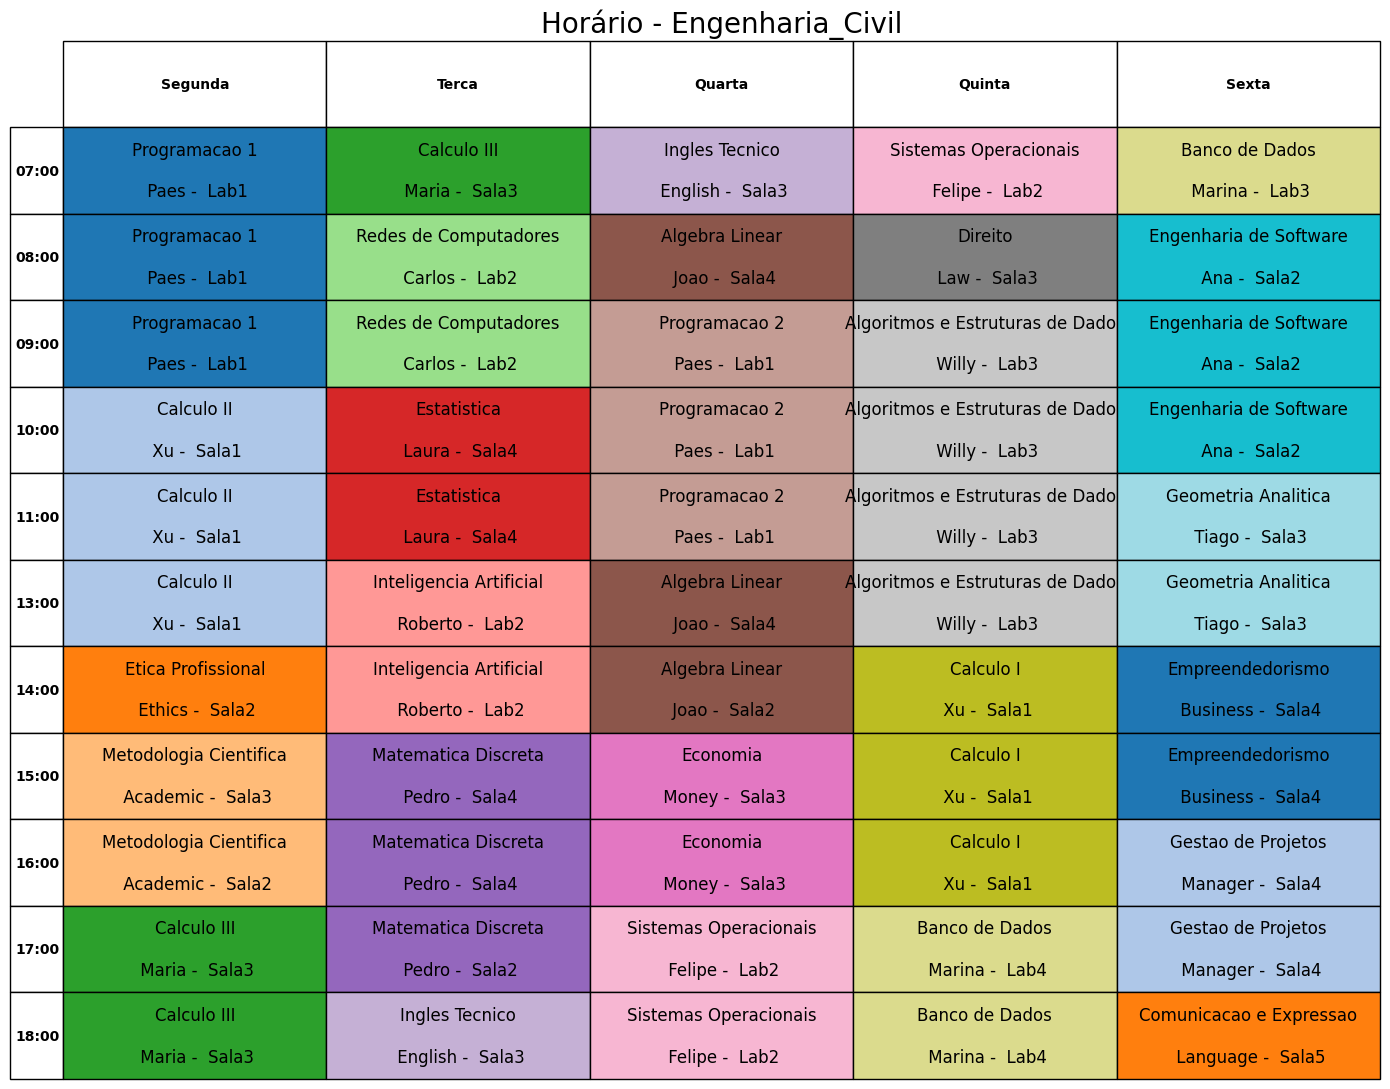

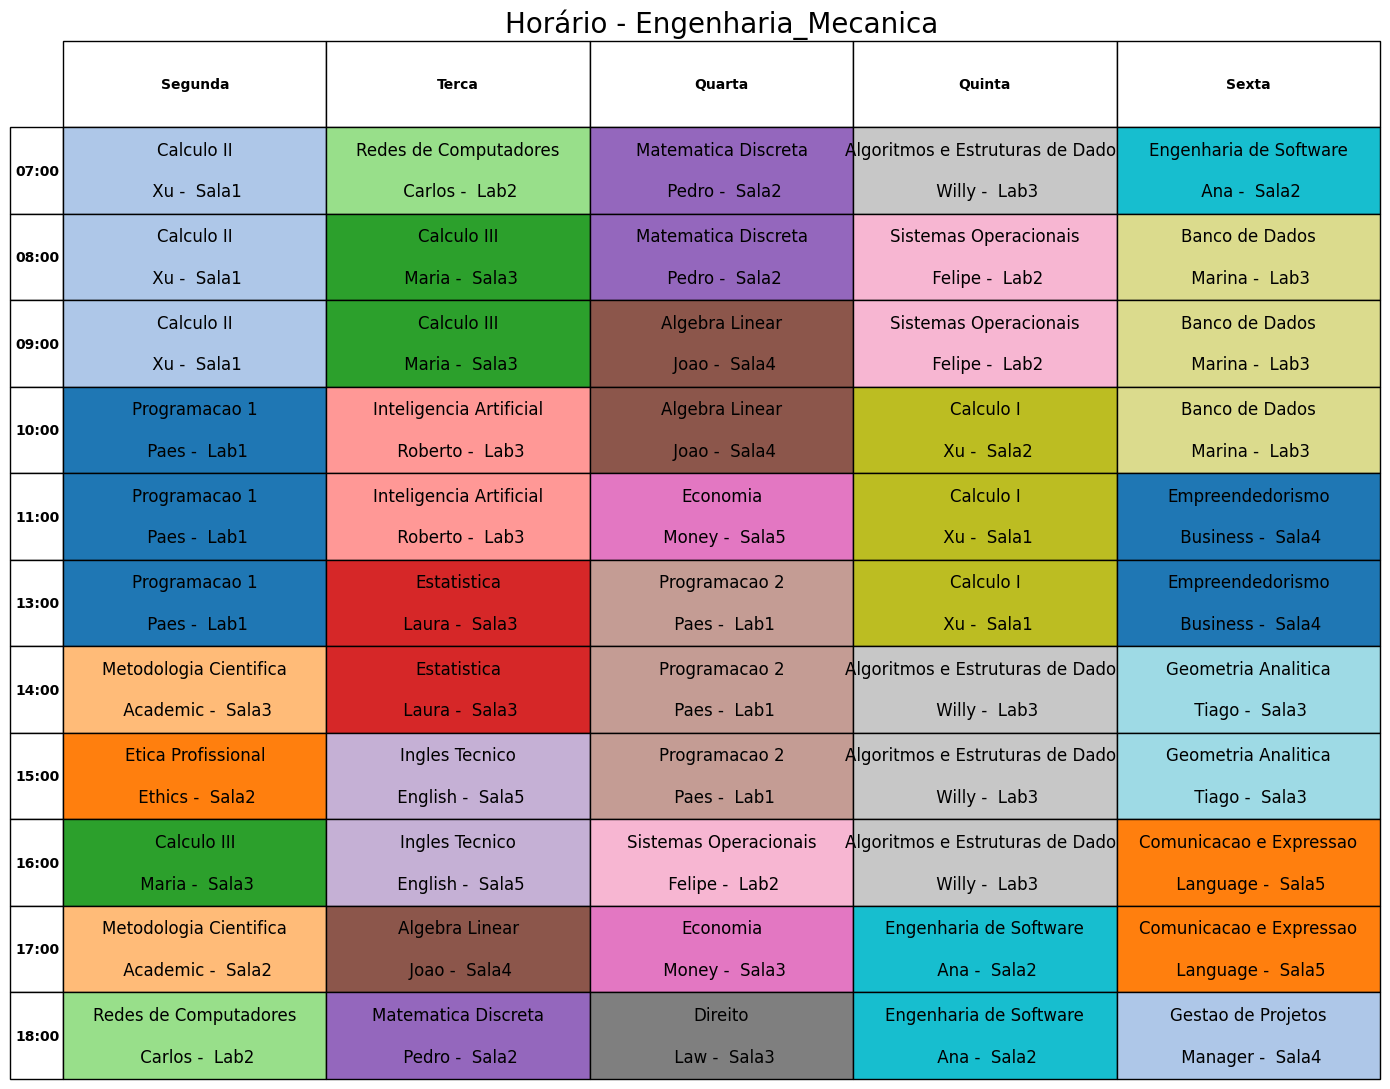

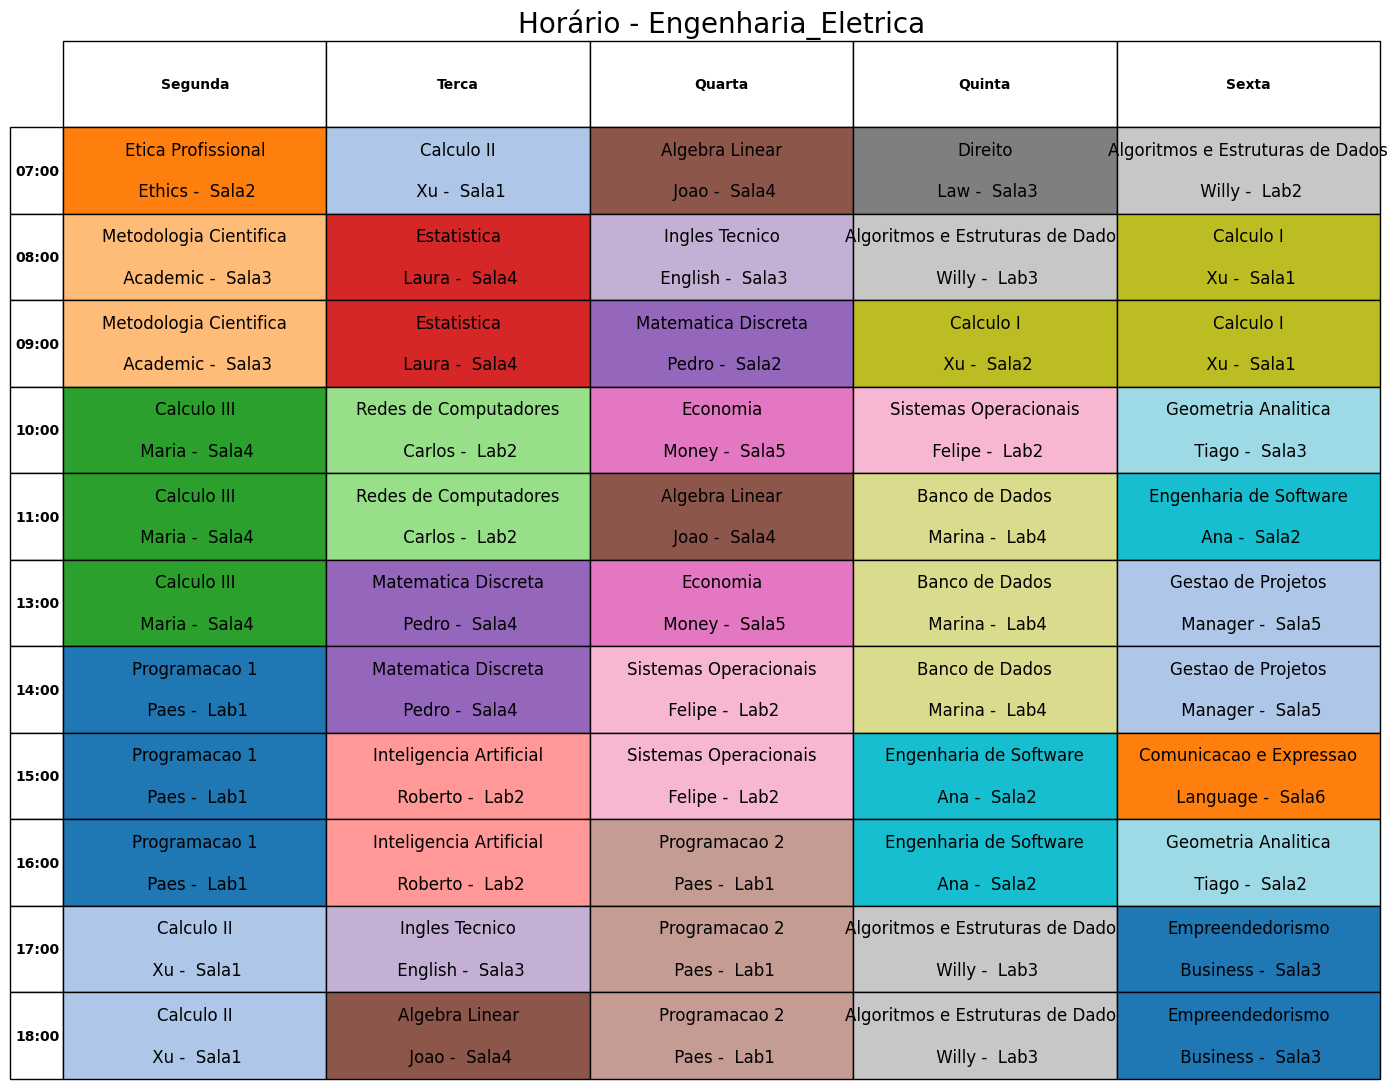

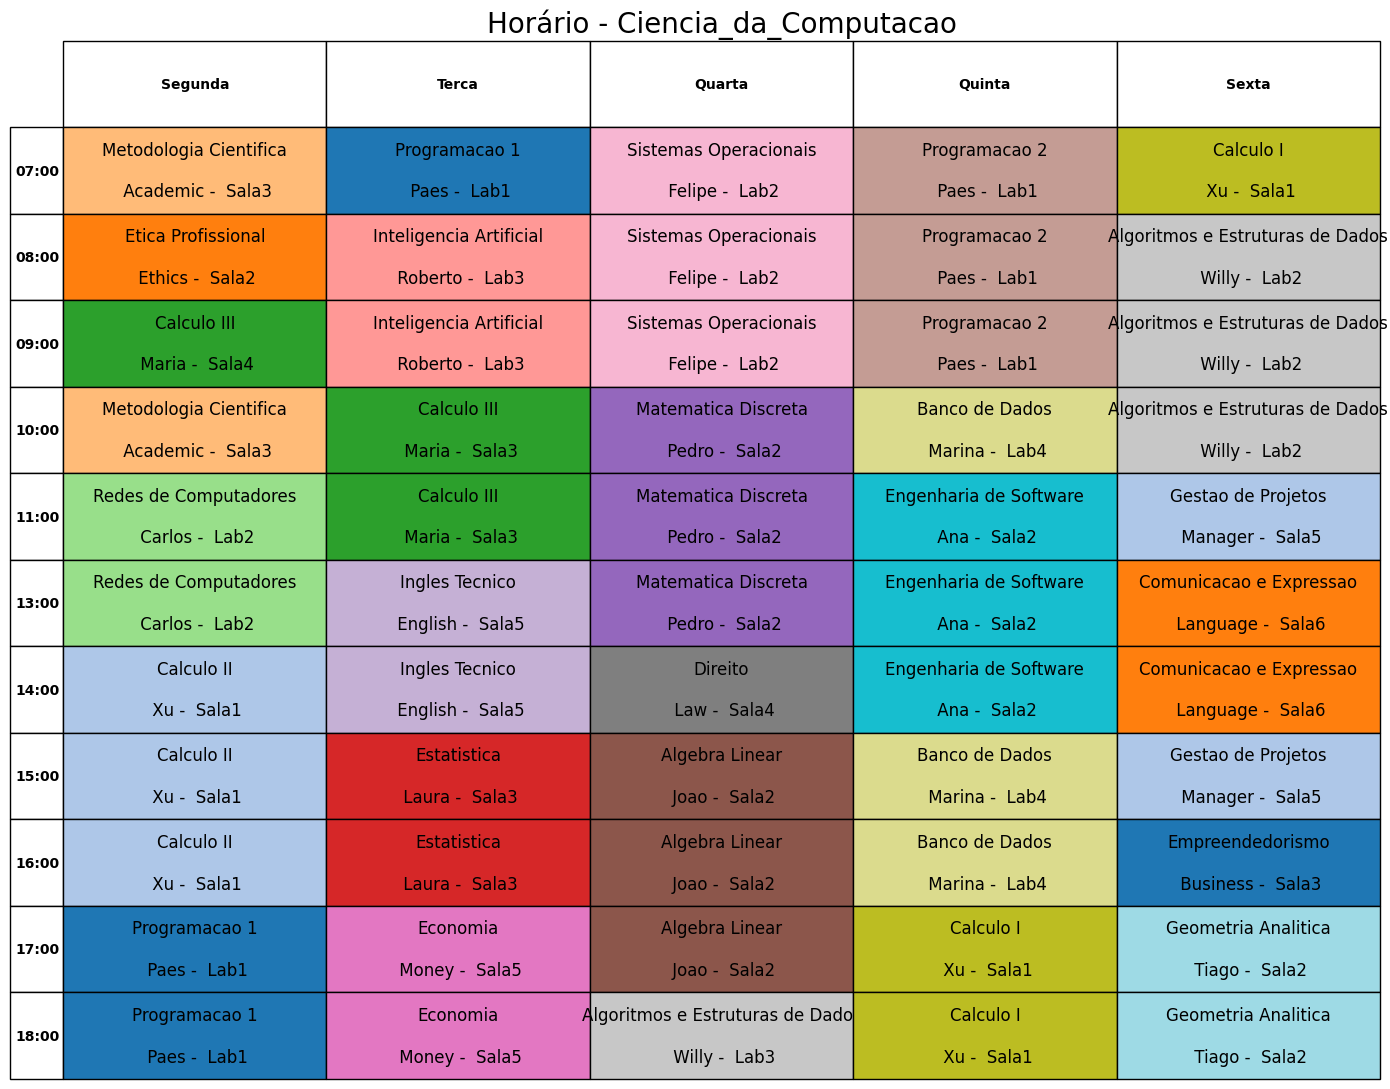

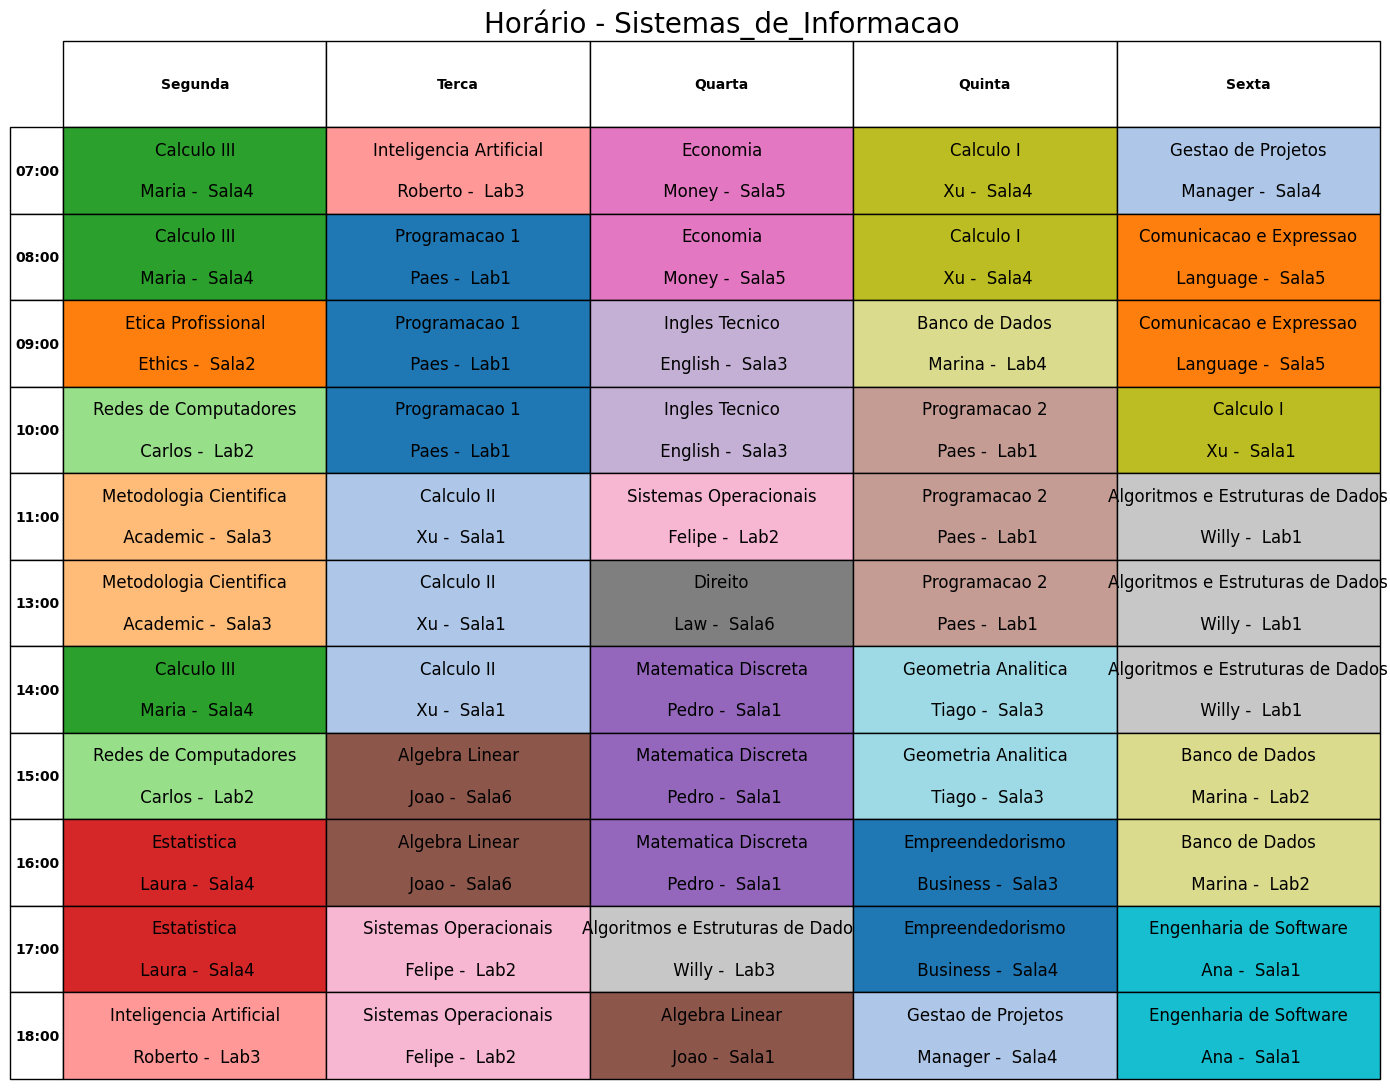

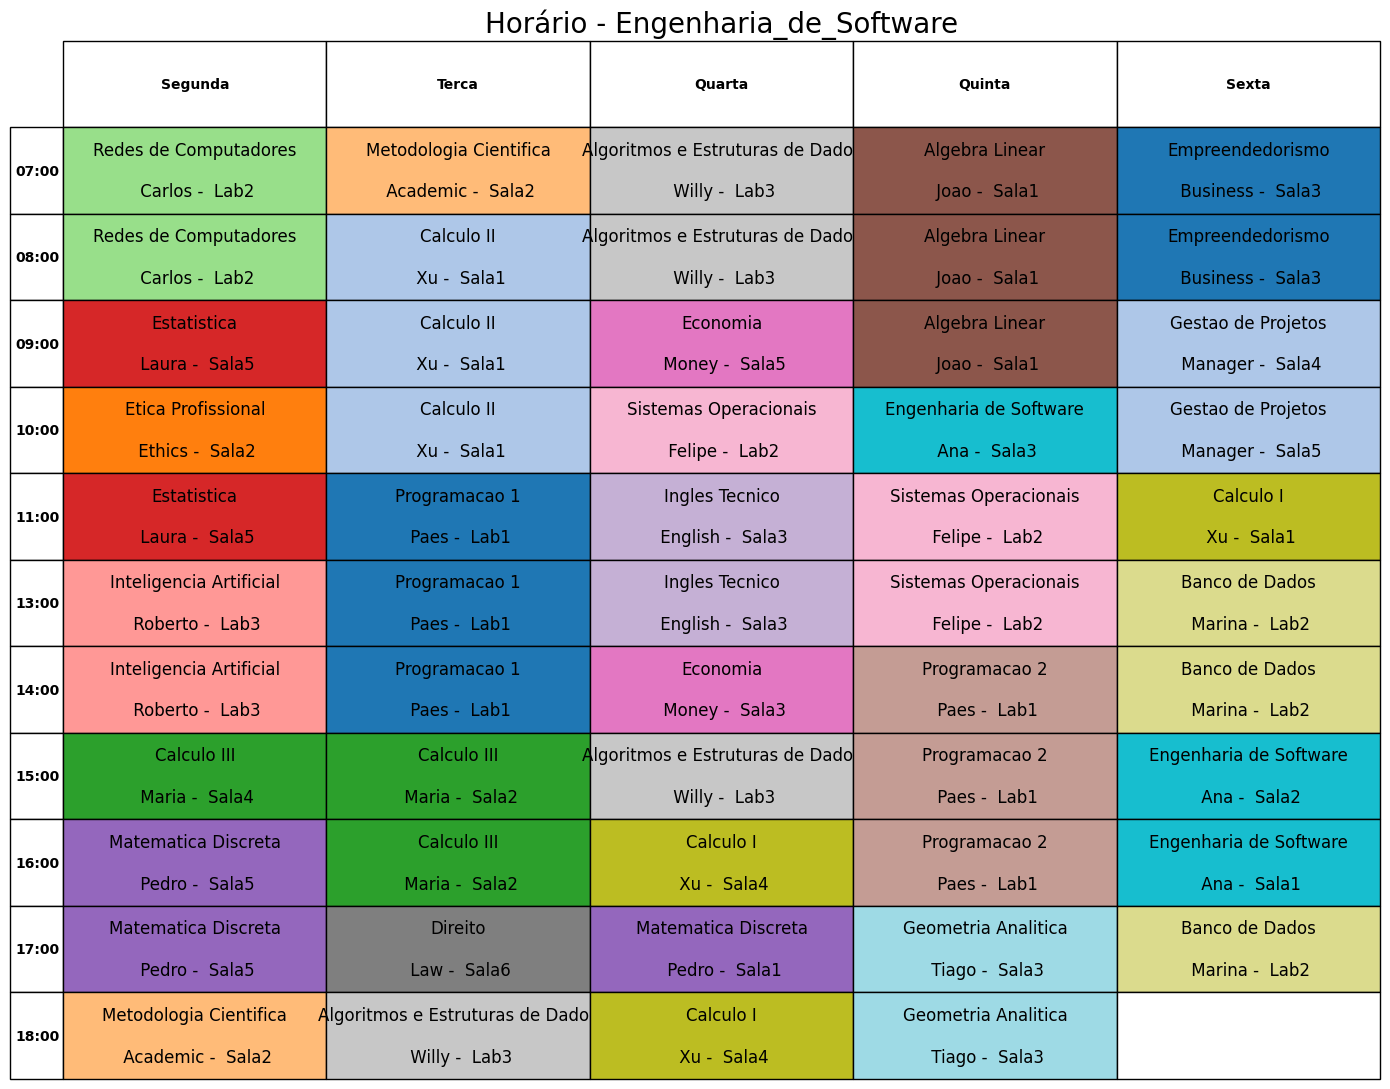

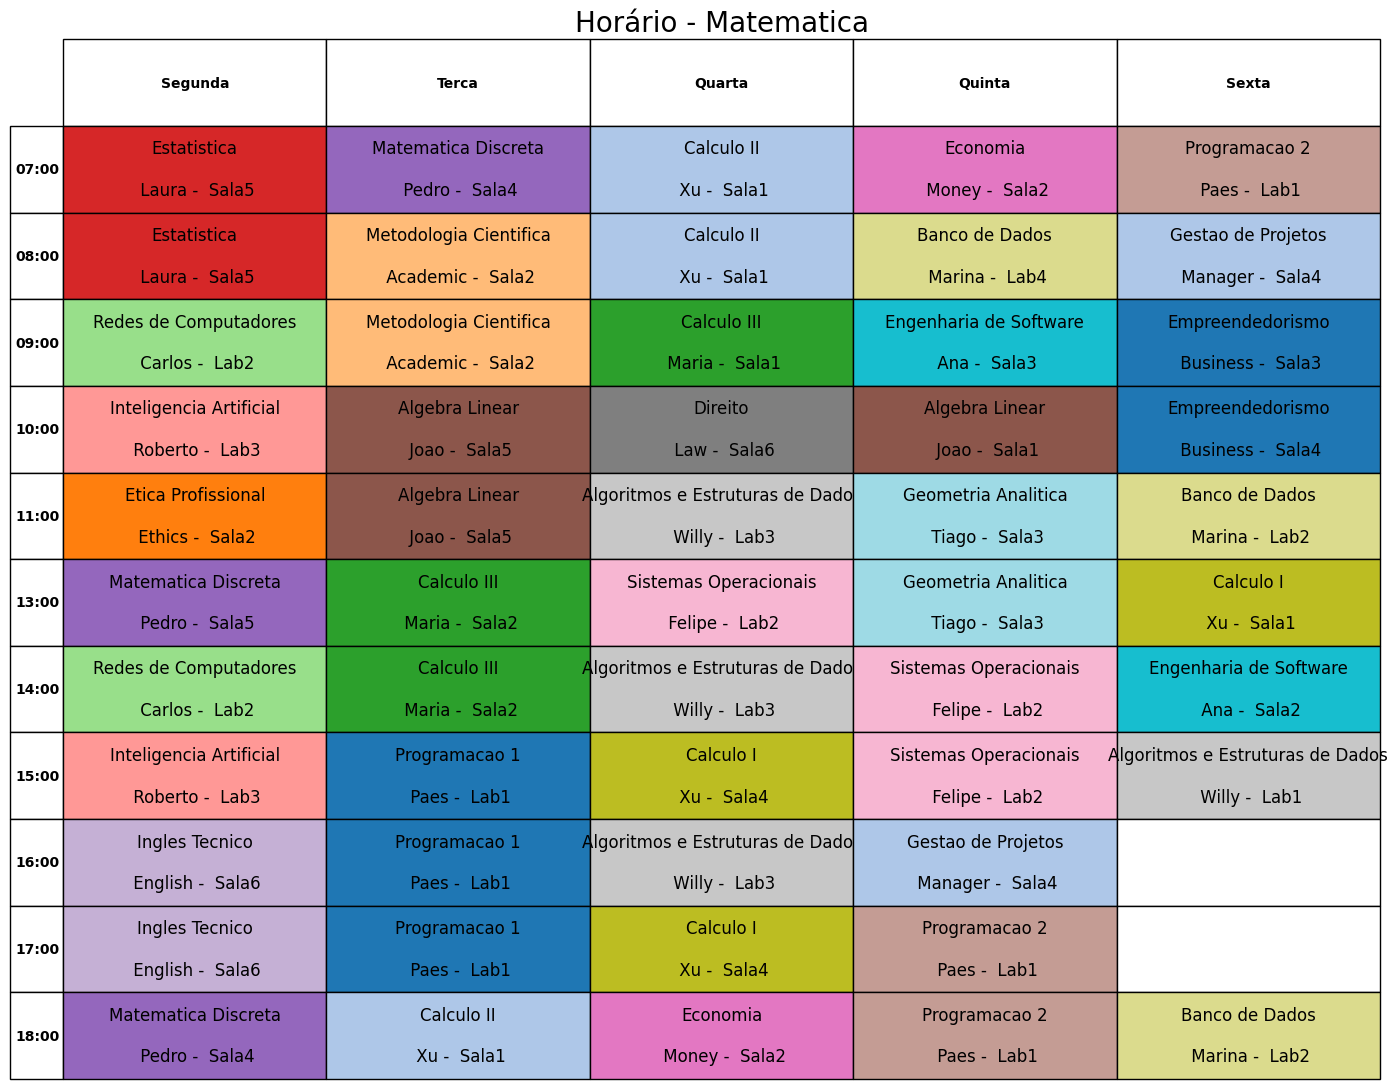

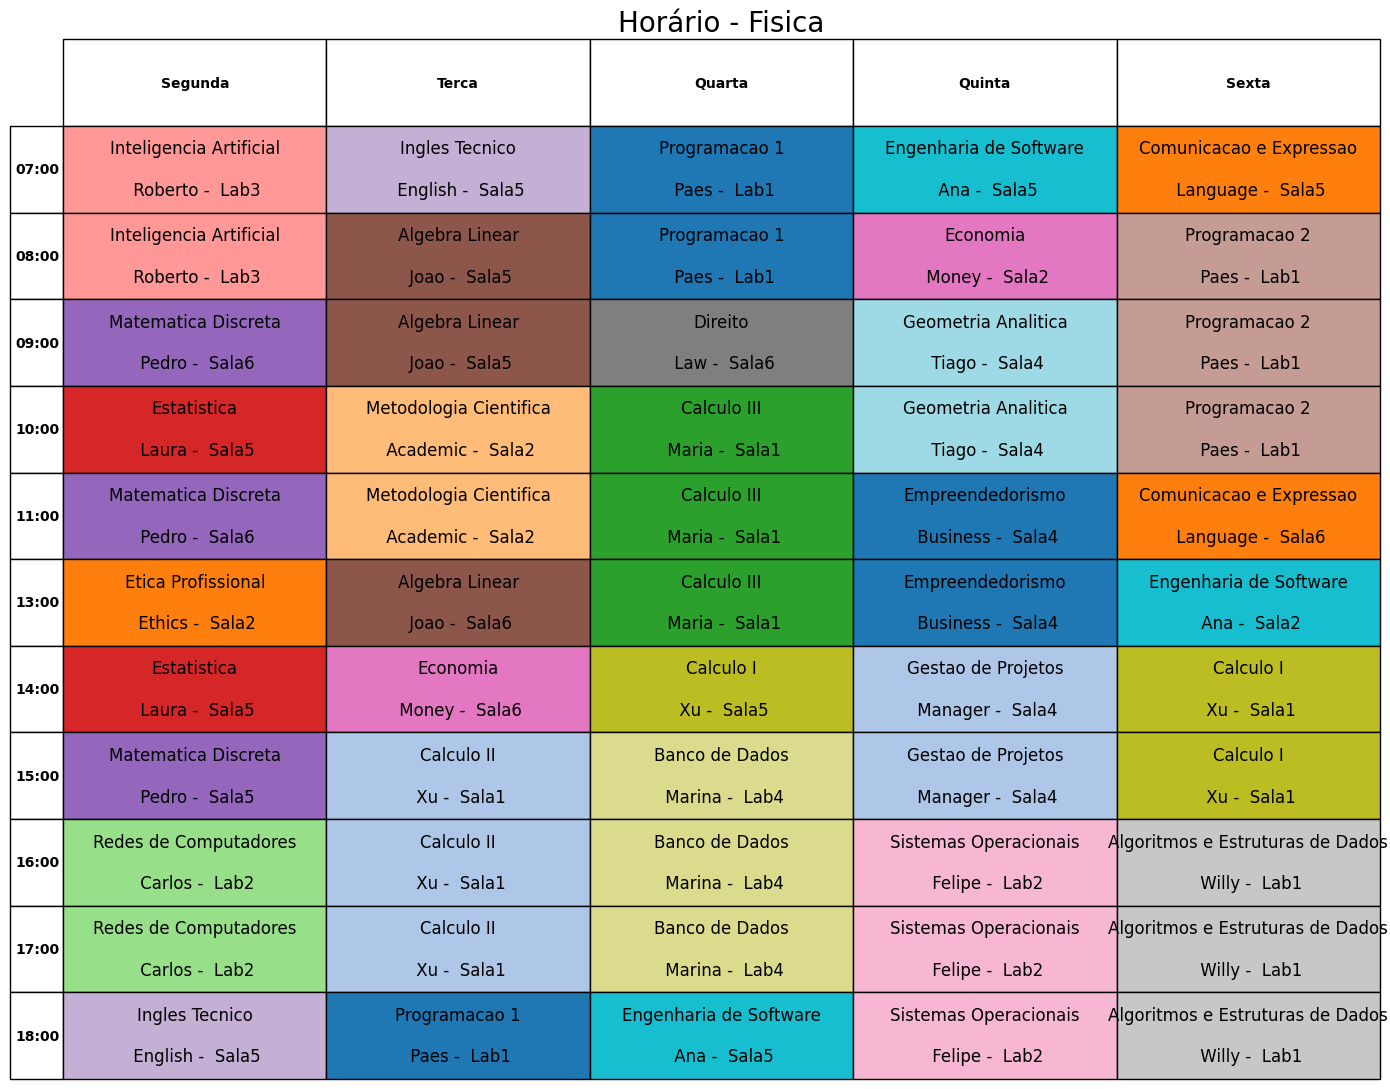

In [33]:
tab20 = ListedColormap(plt.cm.tab20.colors)
subject_color_mapping = {}

def plot_time_table(time_table, title):
    fig, ax = plt.subplots(figsize=(14, len(hours)))  # altura proporcional à quantidade de horários
    ax.set_title(title, fontsize=20)
    ax.axis('off')

    cell_text = [
        [val.replace(',', '\n') if isinstance(val, str) else '' for val in row]
        for row in time_table.values
    ]

    color_array = [
        [subject_color_mapping.get(val.split(',')[0].strip(), 'white') if isinstance(val, str) else 'white'
         for val in row]
        for row in time_table.values
    ]

    table = ax.table(
        cellText=cell_text,
        cellLoc='center',
        colLabels=time_table.columns,
        rowLabels=time_table.index,
        cellColours=color_array,
        bbox=[0, 0, 1, 1]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)

    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == -1:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        else:
            text = cell.get_text().get_text()
            if text:
                parts = text.split("\n")
                first_part = parts[0]
                remaining_part = ' - '.join(parts[1:])
                cell.get_text().set_text(first_part + '\n\n' + remaining_part)

    plt.tight_layout()
    plt.show()



def get_time_table(individual, class_name):
    time_table = pd.DataFrame(index=hours, columns=days)
    class_idx = classes.index(class_name)

    for day_idx, day_name in enumerate(days):
        for hour_idx, hour_label in enumerate(hours):
            gene_index = hour_idx + day_idx * LEN_HOURS + class_idx * LEN_DAYS * LEN_HOURS
            for col_idx in range(LEN_COLS):
                if individual["genes"][gene_index, col_idx] > 0:
                    subject, room_type, lecturer, _ = cols[col_idx]
                    room_type_idx = rooms["type"].index(room_type)
                    room_offset = sum(rooms["number"][:room_type_idx])
                    room_number = individual["genes"][gene_index, col_idx] - 1 - room_offset
                    value = f"{subject}, {lecturer}, {room_type}{room_number + 1}"

                    # Preencha apenas se a célula estiver vazia
                    if pd.isna(time_table.loc[hour_label, day_name]):
                        time_table.loc[hour_label, day_name] = value
                    else:
                        # Evita sobrescrever ou permite múltiplas alocações na mesma célula
                        time_table.loc[hour_label, day_name] += f"\n{value}"

                    if subject not in subject_color_mapping:
                        subject_color_mapping[subject] = tab20(len(subject_color_mapping) % 20)
    return time_table



for class_name in classes:
    timetable = get_time_table(best, class_name)
    plot_time_table(timetable, title=f"Horário - {class_name}")

In [34]:
def report_unallocated_classes(individual):
    print("\n📋 Relatório de Disciplinas Não Alocadas:\n")
    has_unallocated = False
    for class_idx, class_name in enumerate(classes):
        for col_idx, (subject, room_type, lecturer, units) in enumerate(cols):
            base = class_idx * LEN_DAYS * LEN_HOURS
            allocated = sum(individual["genes"][base + i, col_idx] > 0 for i in range(LEN_DAYS * LEN_HOURS))
            if allocated < units:
                has_unallocated = True
                print(f"❌ {class_name}: {subject} com {lecturer} – alocadas {allocated} de {units} unidades")
    if not has_unallocated:
        print("✅ Todas as disciplinas foram alocadas com sucesso!")


report_unallocated_classes(best)



📋 Relatório de Disciplinas Não Alocadas:

❌ Engenharia_Civil: Comunicacao e Expressao com Language – alocadas 1 de 2 unidades
❌ Engenharia_Mecanica: Gestao de Projetos com Manager – alocadas 1 de 2 unidades
❌ Engenharia_Eletrica: Comunicacao e Expressao com Language – alocadas 1 de 2 unidades
❌ Ciencia_da_Computacao: Empreendedorismo com Business – alocadas 1 de 2 unidades
❌ Sistemas_de_Informacao: Engenharia de Software com Ana – alocadas 2 de 3 unidades
❌ Engenharia_de_Software: Comunicacao e Expressao com Language – alocadas 0 de 2 unidades
❌ Matematica: Engenharia de Software com Ana – alocadas 2 de 3 unidades
❌ Matematica: Comunicacao e Expressao com Language – alocadas 0 de 2 unidades
❌ Fisica: Algoritmos e Estruturas de Dados com Willy – alocadas 3 de 4 unidades
